In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt

exposures = "CCP_example.xlsx"

exposures = pd.read_excel(exposures,index_col=0)
display(exposures)

,A,B,C,D,E
A,NaN,30.0,0.0,0.0,25.0
B,20.0,NaN,10.0,0.0,60.0
C,35.0,25.0,NaN,40.0,0.0
D,30.0,0.0,0.0,NaN,0.0
E,0.0,40.0,45.0,0.0,NaN


In [2]:
def add_input_outputs(exposures):
    total_exposures = exposures.copy()
    total_exposures['total out'] = exposures.sum(axis=1)
    total_exposures = total_exposures.append( \
        total_exposures.sum(axis=0).rename(index='total in'))
    
    total_out, total_in = total_exposures.loc[:,'total out'], total_exposures.loc["total in",:]
    net_flow = total_in - total_out
    net_flow_df = pd.DataFrame(net_flow[:-2], columns=['net flow']).transpose()
    return total_exposures, net_flow_df

total_exposures, net_flow = add_input_outputs(exposures)
display(total_exposures); display(net_flow)

,A,B,C,D,E,total out
A,NaN,30.0,0.0,0.0,25.0,55.0
B,20.0,NaN,10.0,0.0,60.0,90.0
C,35.0,25.0,NaN,40.0,0.0,100.0
D,30.0,0.0,0.0,NaN,0.0,30.0
E,0.0,40.0,45.0,0.0,NaN,85.0
total in,85.0,95.0,55.0,40.0,85.0,360.0


,A,B,C,D,E
net flow,30.0,5.0,-45.0,10.0,0.0


In [3]:
def compute_net_exposures(exposures):
    net = exposures.copy()
    for c in net.columns:
        for r in net.columns:
            if r != c:
                net.loc[r,c] = max(0,  exposures.loc[r,c] - exposures.loc[c,r])
    return net

net = compute_net_exposures(exposures)

total_net, net_net_flow = add_input_outputs(net)
display(total_net); display(net_net_flow)

,A,B,C,D,E,total out
A,NaN,10.0,0.0,0.0,25.0,35.0
B,0.0,NaN,0.0,0.0,20.0,20.0
C,35.0,15.0,NaN,40.0,0.0,90.0
D,30.0,0.0,0.0,NaN,0.0,30.0
E,0.0,0.0,45.0,0.0,NaN,45.0
total in,65.0,25.0,45.0,40.0,45.0,220.0


,A,B,C,D,E
net flow,30.0,5.0,-45.0,10.0,0.0


# default costs
## without netting: zero the line assuming no outflows, keeping inflows
## with netting: zero the line and column assuming no inflows or outflows

In [4]:
def default_scenario(exposures, i):
    """zero row(s) for defaulted counterparties in the i-vector"""
    e_size = len(exposures)
    no_defaults = np.ones([e_size, e_size])
    for ii in i:
        no_defaults[ii] = np.zeros([e_size])
    default_exposures = exposures.multiply(no_defaults)
    
    exposure, flow = add_input_outputs(default_exposures)
    for ii in i:
        flow.iloc[0,ii] = None
    return exposure, flow

total_exposures, net_flow = add_input_outputs(exposures)
print("flows and net flows")
display(total_exposures); display(net_flow)

total_exposures, net_flow = default_scenario(exposures,[0])
print("flows and net flows after A defaults")
display(total_exposures); display(net_flow)

flows and net flows


,A,B,C,D,E,total out
A,NaN,30.0,0.0,0.0,25.0,55.0
B,20.0,NaN,10.0,0.0,60.0,90.0
C,35.0,25.0,NaN,40.0,0.0,100.0
D,30.0,0.0,0.0,NaN,0.0,30.0
E,0.0,40.0,45.0,0.0,NaN,85.0
total in,85.0,95.0,55.0,40.0,85.0,360.0


,A,B,C,D,E
net flow,30.0,5.0,-45.0,10.0,0.0


flows and net flows after A defaults


,A,B,C,D,E,total out
A,NaN,0.0,0.0,0.0,0.0,0.0
B,20.0,NaN,10.0,0.0,60.0,90.0
C,35.0,25.0,NaN,40.0,0.0,100.0
D,30.0,0.0,0.0,NaN,0.0,30.0
E,0.0,40.0,45.0,0.0,NaN,85.0
total in,85.0,65.0,55.0,40.0,60.0,305.0


,A,B,C,D,E
net flow,NaN,-25.0,-45.0,10.0,-25.0


In [5]:
total_exposures, net_flow = add_input_outputs(exposures)
display(total_exposures); display(net_flow)
def display_net_flow_post_default(exposures):
    default_flow=[]
    for i,_ in enumerate(exposures.columns): 
        _, default_net_flow = default_scenario(exposures, [i])
        default_net_flow.index = [f"default {exposures.columns[i]} net flow"]
        default_flow.append(default_net_flow)
    
    return pd.concat(default_flow)

print("net flows after a default")
display(display_net_flow_post_default(exposures))

,A,B,C,D,E,total out
A,NaN,30.0,0.0,0.0,25.0,55.0
B,20.0,NaN,10.0,0.0,60.0,90.0
C,35.0,25.0,NaN,40.0,0.0,100.0
D,30.0,0.0,0.0,NaN,0.0,30.0
E,0.0,40.0,45.0,0.0,NaN,85.0
total in,85.0,95.0,55.0,40.0,85.0,360.0


,A,B,C,D,E
net flow,30.0,5.0,-45.0,10.0,0.0


net flows after a default


,A,B,C,D,E
default A net flow,NaN,-25.0,-45.0,10.0,-25.0
default B net flow,10.0,NaN,-55.0,10.0,-60.0
default C net flow,-5.0,-20.0,NaN,-30.0,0.0
default D net flow,0.0,5.0,-45.0,NaN,0.0
default E net flow,30.0,-35.0,-90.0,10.0,NaN


In [6]:
display(net_flow)
def display_net_flow_loss_post_default(exposures):
    default_flow_loss=[]
    for i,_ in enumerate(exposures.columns): 
        _, default_net_flow = default_scenario(exposures, [i])
        default_loss = default_net_flow - net_flow
        default_loss.index = [f"{exposures.columns[i]} default loss"]
        default_flow_loss.append(default_loss)

    return pd.concat(default_flow_loss)

exposure_loss = display_net_flow_loss_post_default(exposures)
print("losses without netting")
display(exposure_loss)

,A,B,C,D,E
net flow,30.0,5.0,-45.0,10.0,0.0


losses without netting


,A,B,C,D,E
A default loss,NaN,-30.0,0.0,0.0,-25.0
B default loss,-20.0,NaN,-10.0,0.0,-60.0
C default loss,-35.0,-25.0,NaN,-40.0,0.0
D default loss,-30.0,0.0,0.0,NaN,0.0
E default loss,0.0,-40.0,-45.0,0.0,NaN


In [7]:
netted_loss = display_net_flow_loss_post_default(net)
print("losses with netting")
display(netted_loss)

losses with netting


,A,B,C,D,E
A default loss,NaN,-10.0,0.0,0.0,-25.0
B default loss,0.0,NaN,0.0,0.0,-20.0
C default loss,-35.0,-15.0,NaN,-40.0,0.0
D default loss,-30.0,0.0,0.0,NaN,0.0
E default loss,0.0,0.0,-45.0,0.0,NaN


In [8]:
print("additional losses when exposures are not netted")
display(exposure_loss - netted_loss)

additional losses when exposures are not netted


,A,B,C,D,E
A default loss,NaN,-20.0,0.0,0.0,0.0
B default loss,-20.0,NaN,-10.0,0.0,-40.0
C default loss,0.0,-10.0,NaN,0.0,0.0
D default loss,0.0,0.0,0.0,NaN,0.0
E default loss,0.0,-40.0,0.0,0.0,NaN


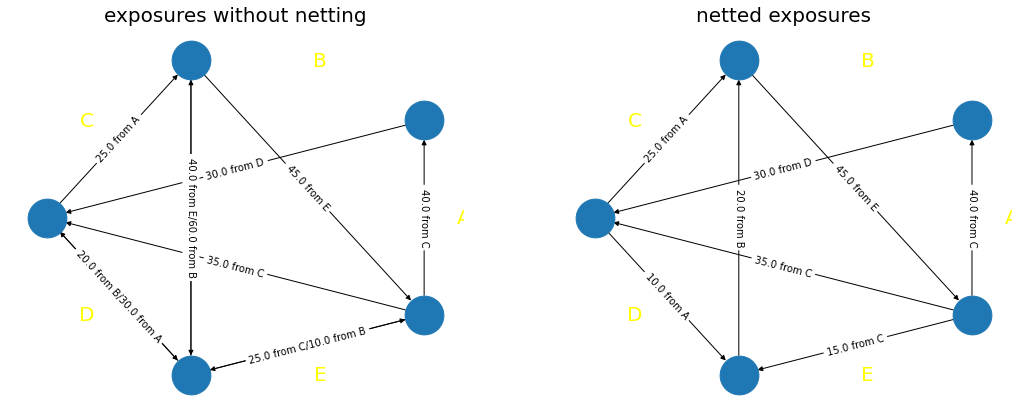

In [9]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def plot_network(matrix, title):
    DG = nx.MultiDiGraph()
    node_labels = matrix.columns
    DG.add_nodes_from(range(1,len(node_labels)))

    edges = []
    for j, (column,row) in enumerate(zip(matrix.values, matrix.transpose().values)):
        for i, (cvalue, rvalue) in enumerate(zip(column,row)):
            if i > j:
                if rvalue > 0 and cvalue <= 0:
                    edges.append(((i+1, j+1), f"{rvalue} from {node_labels[i]}"))
                if cvalue > 0 and rvalue <= 0:
                    edges.append(((j+1, i+1), f"{cvalue} from {node_labels[j]}"))
                if rvalue > 0 and cvalue > 0:
                    edges.append(((i+1, j+1), \
                            f"{rvalue} from {node_labels[i]}/{cvalue} from {node_labels[j]}"))
                    edges.append(((j+1, i+1), ""))

    edge_labels = dict(edges)
    directed_edges = [(i,j,x) for (i,j),x in edges]
    DG.add_edges_from(directed_edges)

    labels = dict([(i+1,lab) for i,lab in enumerate(node_labels)])

    z = nx.draw_shell(DG, with_labels=False, node_size=1500, font_size=25, \
                      font_color="yellow", font_weight="bold")
    pos = nx.circular_layout(DG)
    pos2 = dict()
    for k,p in pos.items():
        pos2[k] = p * [-1,-1]

    edge_labels=nx.draw_networkx_edge_labels(DG, pos2, edge_labels=edge_labels)

    nx.draw_networkx_labels(DG, pos, labels, font_size=20, font_color="yellow")
    plt.title(title, fontsize=20)
#     plt.show()

plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
plot_network(exposures, "exposures without netting")
plt.subplot(1,2,2)
plot_network(net, "netted exposures")
plt.show()

## determine cascading sequence of defaults

In [10]:
exp, net0 = add_input_outputs(exposures)
print("flows and net flows")
display(total_exposures); display(net_flow)
print('')

def get_default_cascade(exposures, additional_defaults, cutoff, printit=True):
    """start with a default and loop through the sequence of additional defaults"""
    exp, net0 = add_input_outputs(exposures)
    which_i = []
    max_iters = 0
    while len(additional_defaults) > 0 and max_iters <= 7:
        max_iters += 1
        which_i.extend(additional_defaults)
        exp1, net1 = default_scenario(exposures, [which_i])
        additional_losses = net1 - net0
        additional_defaults = np.arange(additional_losses.shape[1])[additional_losses.iloc[0] < cutoff]
        if printit:
            print('-------------------------------------------------------------')
            print("default by ",which_i)
            display(exp1), display(net1)
            print("additional losses")
            display(additional_losses)
    return which_i

get_default_cascade(exposures, [1], -55, True) 

flows and net flows


,A,B,C,D,E,total out
A,NaN,30.0,0.0,0.0,25.0,55.0
B,20.0,NaN,10.0,0.0,60.0,90.0
C,35.0,25.0,NaN,40.0,0.0,100.0
D,30.0,0.0,0.0,NaN,0.0,30.0
E,0.0,40.0,45.0,0.0,NaN,85.0
total in,85.0,95.0,55.0,40.0,85.0,360.0


,A,B,C,D,E
net flow,30.0,5.0,-45.0,10.0,0.0



-------------------------------------------------------------
default by  [1]


,A,B,C,D,E,total out
A,NaN,30.0,0.0,0.0,25.0,55.0
B,0.0,NaN,0.0,0.0,0.0,0.0
C,35.0,25.0,NaN,40.0,0.0,100.0
D,30.0,0.0,0.0,NaN,0.0,30.0
E,0.0,40.0,45.0,0.0,NaN,85.0
total in,65.0,95.0,45.0,40.0,25.0,270.0


,A,B,C,D,E
net flow,10.0,NaN,-55.0,10.0,-60.0


additional losses


,A,B,C,D,E
net flow,-20.0,NaN,-10.0,0.0,-60.0


-------------------------------------------------------------
default by  [1, 4]


,A,B,C,D,E,total out
A,NaN,30.0,0.0,0.0,25.0,55.0
B,0.0,NaN,0.0,0.0,0.0,0.0
C,35.0,25.0,NaN,40.0,0.0,100.0
D,30.0,0.0,0.0,NaN,0.0,30.0
E,0.0,0.0,0.0,0.0,NaN,0.0
total in,65.0,55.0,0.0,40.0,25.0,185.0


,A,B,C,D,E
net flow,10.0,NaN,-100.0,10.0,NaN


additional losses


,A,B,C,D,E
net flow,-20.0,NaN,-55.0,0.0,NaN


[1, 4]

# HW

In [11]:
def default_scenario_2(exposures, i, k):
    return default_scenario(exposures,[i,k])

total_exposures, net_flow = add_input_outputs(exposures)
print("flows and net flows")
display(total_exposures); display(net_flow)

def display_net_flow_loss_post_default_2(exposures):
    default_flow_loss=[]
    for i,_ in enumerate(exposures.columns): 
        for k,_ in enumerate(exposures.columns):
            if i < k:
                _, default_net_flow = default_scenario_2(exposures, i, k)
                default_loss = default_net_flow - net_flow
                default_loss.index = [f"{exposures.columns[i]} & {exposures.columns[k]} default loss"]
                default_flow_loss.append(default_loss)

    return pd.concat(default_flow_loss)

print("net flow losses for default scenarios")
net_flow_loss_2 = display_net_flow_loss_post_default_2(exposures)
net_flow_loss_2

flows and net flows


,A,B,C,D,E,total out
A,NaN,30.0,0.0,0.0,25.0,55.0
B,20.0,NaN,10.0,0.0,60.0,90.0
C,35.0,25.0,NaN,40.0,0.0,100.0
D,30.0,0.0,0.0,NaN,0.0,30.0
E,0.0,40.0,45.0,0.0,NaN,85.0
total in,85.0,95.0,55.0,40.0,85.0,360.0


,A,B,C,D,E
net flow,30.0,5.0,-45.0,10.0,0.0


net flow losses for default scenarios


,A,B,C,D,E
A & B default loss,NaN,NaN,-10.0,0.0,-85.0
A & C default loss,NaN,-55.0,NaN,-40.0,-25.0
A & D default loss,NaN,-30.0,0.0,NaN,-25.0
A & E default loss,NaN,-70.0,-45.0,0.0,NaN
B & C default loss,-55.0,NaN,NaN,-40.0,-60.0
B & D default loss,-50.0,NaN,-10.0,NaN,-60.0
B & E default loss,-20.0,NaN,-55.0,0.0,NaN
C & D default loss,-65.0,-25.0,NaN,NaN,0.0
C & E default loss,-35.0,-65.0,NaN,-40.0,NaN
D & E default loss,-30.0,-40.0,-45.0,NaN,NaN


In [12]:
min_scenario = [' '] * net_flow_loss_2.shape[0]
min_scenario[np.nanargmin(net_flow_loss_2['C'].values)] ='MAX LOSS'
net_flow_loss_2["largest loss"] = min_scenario
net_flow_loss_2

,A,B,C,D,E,largest loss
A & B default loss,NaN,NaN,-10.0,0.0,-85.0,
A & C default loss,NaN,-55.0,NaN,-40.0,-25.0,
A & D default loss,NaN,-30.0,0.0,NaN,-25.0,
A & E default loss,NaN,-70.0,-45.0,0.0,NaN,
B & C default loss,-55.0,NaN,NaN,-40.0,-60.0,
B & D default loss,-50.0,NaN,-10.0,NaN,-60.0,
B & E default loss,-20.0,NaN,-55.0,0.0,NaN,MAX LOSS
C & D default loss,-65.0,-25.0,NaN,NaN,0.0,
C & E default loss,-35.0,-65.0,NaN,-40.0,NaN,
D & E default loss,-30.0,-40.0,-45.0,NaN,NaN,


In [13]:
print("net flow losses for default scenarios when exposures are netted")
display(display_net_flow_loss_post_default_2(net))

net flow losses for default scenarios when exposures are netted


,A,B,C,D,E
A & B default loss,NaN,NaN,0.0,0.0,-45.0
A & C default loss,NaN,-25.0,NaN,-40.0,-25.0
A & D default loss,NaN,-10.0,0.0,NaN,-25.0
A & E default loss,NaN,-10.0,-45.0,0.0,NaN
B & C default loss,-35.0,NaN,NaN,-40.0,-20.0
B & D default loss,-30.0,NaN,0.0,NaN,-20.0
B & E default loss,0.0,NaN,-45.0,0.0,NaN
C & D default loss,-65.0,-15.0,NaN,NaN,0.0
C & E default loss,-35.0,-15.0,NaN,-40.0,NaN
D & E default loss,-30.0,0.0,-45.0,NaN,NaN
